# Texas
We will be analyzing the congressional district map in Texas followwing the 2020 census. Currently Texas's congressional map is in litigation so we want to examine how that could have effected the 2024 U.S. House election. We will be looking at their 2021 plan which was used for the 2022 and 2024 election.

## Import Required Packages

In [71]:
# For working with graphs
import networkx as nx

# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrychain
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup

## Analysis of maps by senate voting

Now that we have set up the data, we can start our analysis!

We want to determine what party would have won the election for the U.S. House of Representative in each district for each of the two maps we have for Texas. However, instead of using House candidates, we will be using U.S. Presidential candidates because all Texans votedd for the same candidates and because in the next part, once we move the congressional district boundary using a random walk, the candidates for the House would change. We are assuming voters would vote by party so we will use a statewide election where there were two candidates, one from each party, to determine how each voters would vote in a new House election.

In [72]:
# Read in our saved data frame
tx_data_gdf = gpd.read_file("save-new-data/tx-election-census-data-by-precincts.shp")

In [73]:
# Read in our 2021 congressional district gdp for district boundaries
tx_2021_gdf = gpd.read_file("PLANC2193/PLANC2193.shp")

### 2021 Congressional Map

We will use the U.S. Presidential election to see what party the candidate for the U.S. House would have been elected from based on the 2021 congressional districting map.  In 2020, Republican Donald Trump (G20PRERTRU) and Democrat Joe Biden (G20PREDBID) ran for the U.S. Presidency.

In [74]:
# Group by congressional district and calculate total votes for each candidate
district_totals = tx_data_gdf.groupby('DIST2021')[['G20PRERTRU', 'G20PREDBID']].sum()

# Determine the winning party in each district
district_totals['Winner-2021'] = np.where(district_totals['G20PREDBID'] > district_totals['G20PRERTRU'], "Democrat", "Republican")

# Reset index to turn District back into a column (optional)
district_totals_2021 = district_totals.reset_index()

print(district_totals_2021)

    DIST2021  G20PRERTRU  G20PREDBID Winner-2021
0          0      233263       85451  Republican
1          1      195333      121928  Republican
2          2      204906      152128  Republican
3          3      216555      125752  Republican
4          4      180386      113485  Republican
5          5      173396      106199  Republican
6          6       96808      180572    Democrat
7          7      194331      110237  Republican
8          8       58289      194767    Democrat
9          9      200250      136773  Republican
10        10      186432       78401  Republican
11        11      188414      129558  Republican
12        12      215255       78945  Republican
13        13      200094      110018  Republican
14        14      115479      109393  Republican
15        15       75690      161361    Democrat
16        16      183624      113886  Republican
17        17       59922      176459    Democrat
18        18      203284       73282  Republican
19        19       8

In [75]:
# Count the number of districts won by each party
winner_summary_2021 = district_totals_2021['Winner-2021'].value_counts()

print(winner_summary_2021)

Winner-2021
Republican    25
Democrat      13
Name: count, dtype: int64


In [76]:
tx_data_gdf = tx_data_gdf.merge(district_totals_2021[["DIST2021", "Winner-2021"]], on='DIST2021', how='left')

<Axes: >

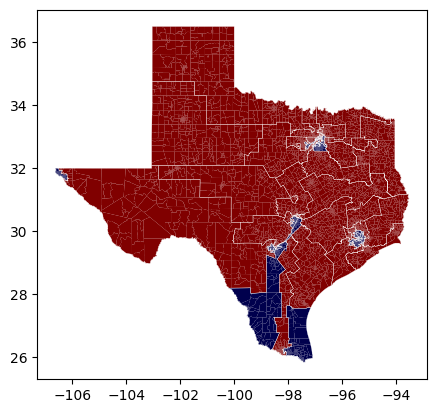

In [77]:
fig, ax = plt.subplots()

# Plot the units with the vote percentage as color
tx_data_gdf.plot(column = "Winner-2021", ax=ax, cmap = "seismic")

# Overlay districts
tx_2021_gdf = tx_2021_gdf.to_crs("EPSG:4269")
tx_2021_gdf.boundary.plot(ax=ax, color='white', linewidth=0.2)

### Setting up and running our Random Walk

In [78]:
tx_graph = Graph.from_file("save-new-data/tx-election-census-data-by-precincts.shp")

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [122]:
# Make an initial districting plan

num_dist = 38 # Number of Congressional Districts in Texas
tot_pop = sum([tx_graph.nodes()[v]['TOTPOP'] for v in tx_graph.nodes()])
ideal_pop = tot_pop/num_dist
pop_tolerance = 0.02
initial_plan = recursive_tree_part(tx_graph, range(num_dist), ideal_pop, 'TOTPOP', pop_tolerance, 10)

The cases against Texas' congressional districting plan claimed that the plan was an unconstitutional racial gerrymander (diluting the power of black and hispanic voters) by violating Section 2 of the Voting Rights Act. For that reason we will examine the black population in addition to the senate election.

In [123]:
#Set up partition object
initial_partition = Partition(
    tx_graph, # dual graph
    assignment = initial_plan, # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("NHBLK", alias = "district BPOP"),
        "district HPOP": Tally("HISPPOP", alias = "district HPOP"),
        "R Votes": Tally("G20PRERTRU", alias = "R Votes"), 
        "D Votes": Tally("G20PREDBID", alias = "D Votes")
    }
) 

In [124]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [125]:
# We contrain the opulation to say with the tolarance we set for an ideal district population
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [126]:
# Now we create our chain
our_random_walk = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 15000
)

In [127]:
bmaj_ensemble = []
d_ensemble = [] 
hmaj_ensemble = [] 
bpop = [] 
dvpop = []
hpop = []

for current_plan in our_random_walk:    
    num_maj_black = 0
    num_maj_hisp = 0
    d = 0
    bpop_this_step = []
    dv_this_step = []
    hpop_this_step = []

    for i in range(num_dist):
        # Calculate number of black-majority districts 
        b_perc = current_plan["district BPOP"][i]/current_plan["district population"][i]
        if b_perc >= 0.37:
            num_maj_black += 1

        # Calculate number of hispanic-majority districts 
        h_perc = current_plan["district HPOP"][i]/current_plan["district population"][i]
        if h_perc >= 0.37:
            num_maj_hisp += 1
        
        # Calculate number of districts with more Democratic votes than Republican votes
        if current_plan["R Votes"][i] < current_plan["D Votes"][i]: 
            d = d + 1

        # Calculate the percentage of black population for each district at each step
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)

        # Calculate the percentage of hispanic population for each district at each step
        h_perc = current_plan["district HPOP"][i]/ current_plan["district population"][i]
        hpop_this_step.append(h_perc)

         # Calculate the percentage of democratic voters for each district at each step
        dv_perc = current_plan["D Votes"][i]/ current_plan["district population"][i]
        dv_this_step.append(dv_perc)
    
        
    bmaj_ensemble.append(num_maj_black)
    hmaj_ensemble.append(num_maj_hisp)
    d_ensemble.append(d)

    bpop_this_step.sort()
    bpop.append(bpop_this_step)

    hpop_this_step.sort()
    hpop.append(hpop_this_step)

    dv_this_step.sort()
    dvpop.append(bpop_this_step)

bpop_rand = np.array(bpop)
dvpop_rand = np.array(dvpop)
hpop_rand = np.array(hpop)

### Analysis

In the both the 2021 congressional districting plans there were 18 district that elected democratic representatives for the House. Let's see how many democratic districts are likely within the ensemble.

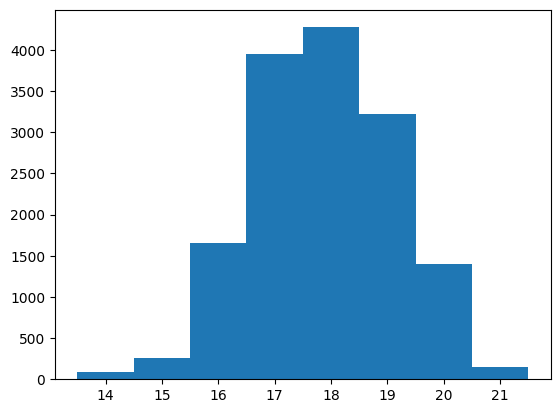

In [128]:
plt.figure()
plt.hist(d_ensemble, bins = [x + 0.5 for x in range(min(set(d_ensemble)) - 1, max(set(d_ensemble)) + 1)])
plt.show()

We see that 18 districts is most likely with 17 districts basically as likely and 19 districts close.

Now, let's look at black majority districts.

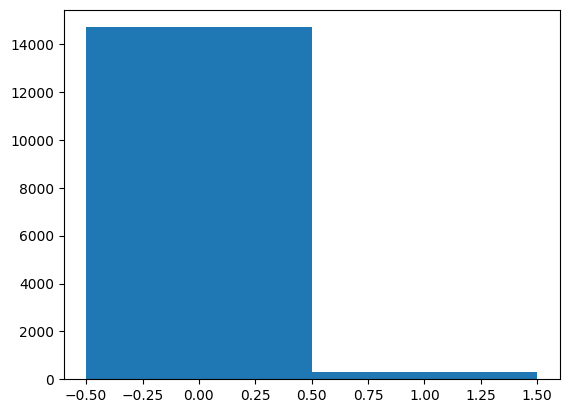

In [129]:
plt.figure()
plt.hist(bmaj_ensemble, bins = [x + 0.5 for x in range(min(set(bmaj_ensemble)) - 1, max(set(bmaj_ensemble)) + 1)])
plt.show()

The ensemble shows that black majority districts aren't that likely.

In [130]:
# Group by congressional district and calculate total votes for each candidate
pop_totals = tx_data_gdf.groupby('DIST2021')[['TOTPOP', 'NHBLK']].sum()

# Determine the winning party in each district
pop_totals['BPER'] = pop_totals['NHBLK'] / pop_totals['TOTPOP']

# Reset index to turn District back into a column (optional)
pop_totals = pop_totals.reset_index()

print(pop_totals)

    DIST2021    TOTPOP     NHBLK      BPER
0          0  759505.0  132083.0  0.173907
1          1  769309.0   85760.0  0.111477
2          2  767377.0   71810.0  0.093579
3          3  771246.0   69429.0  0.090022
4          4  764753.0  105310.0  0.137705
5          5  769329.0  104865.0  0.136307
6          6  770526.0  145091.0  0.188301
7          7  754373.0   93415.0  0.123831
8          8  765399.0  273732.0  0.357633
9          9  773747.0   72421.0  0.093598
10        10  768530.0   83308.0  0.108399
11        11  762653.0   85837.0  0.112551
12        12  763884.0   49510.0  0.064814
13        13  767782.0  117111.0  0.152532
14        14  767543.0    7622.0  0.009930
15        15  749244.0   21353.0  0.028499
16        16  767486.0  115276.0  0.150199
17        17  762192.0  245995.0  0.322747
18        18  769024.0   48025.0  0.062449
19        19  767011.0   42538.0  0.055459
20        20  762083.0   26077.0  0.034218
21        21  763049.0   85572.0  0.112145
22        2

In [131]:
tx_data_gdf = tx_data_gdf.merge(pop_totals[["DIST2021", "BPER"]], on='DIST2021', how='left')

In [132]:
num_maj_black = 0
for i in pop_totals["BPER"]:
    if i >= 0.37: 
        num_maj_black += 1

print("Black majority districts in 2021 plan:", num_maj_black)

Black majority districts in 2021 plan: 1


Now let's look at hispanic majority districts

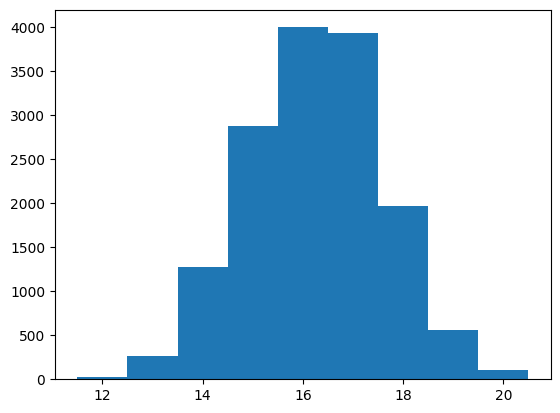

In [133]:
plt.figure()
plt.hist(hmaj_ensemble, bins = [x + 0.5 for x in range(min(set(hmaj_ensemble)) - 1, max(set(hmaj_ensemble)) + 1)])
plt.show()

It seems like 16 or 17 districts is most likely.

In [134]:
# Group by congressional district and calculate total votes for each candidate
pop_totals = tx_data_gdf.groupby('DIST2021')[['TOTPOP', 'HISPPOP']].sum()

# Determine the winning party in each district
pop_totals['HPER'] = pop_totals['HISPPOP'] / pop_totals['TOTPOP']

# Reset index to turn District back into a column (optional)
pop_totals = pop_totals.reset_index()

print(pop_totals)

    DIST2021    TOTPOP   HISPPOP      HPER
0          0  759505.0  129572.0  0.170601
1          1  769309.0  232331.0  0.302000
2          2  767377.0  124274.0  0.161946
3          3  771246.0  109560.0  0.142056
4          4  764753.0  225005.0  0.294219
5          5  769329.0  259858.0  0.337772
6          6  770526.0  231182.0  0.300031
7          7  754373.0  245768.0  0.325791
8          8  765399.0  300878.0  0.393100
9          9  773747.0  192765.0  0.249132
10        10  768530.0  296185.0  0.385392
11        11  762653.0  187715.0  0.246134
12        12  763884.0  214070.0  0.280239
13        13  767782.0  193287.0  0.251747
14        14  767543.0  625421.0  0.814835
15        15  749244.0  616940.0  0.823417
16        16  767486.0  193457.0  0.252066
17        17  762192.0  329813.0  0.432716
18        18  769024.0  294136.0  0.382480
19        19  767011.0  540726.0  0.704978
20        20  762083.0  233367.0  0.306223
21        21  763049.0  216113.0  0.283223
22        2

In [135]:
tx_data_gdf = tx_data_gdf.merge(pop_totals[["DIST2021", "HPER"]], on='DIST2021', how='left')

In [136]:
num_his_black = 0
for i in pop_totals["HPER"]:
    if i >= 0.37: 
        num_his_black += 1

print("Hispanic majority districts in 2021 plan:", num_his_black)

Hispanic majority districts in 2021 plan: 14


The 2021 congressional plan had 1 black majority district and the ensemble had 0. Meanwhile, the 2021 plan had 13 democratic majority districts but the ensemble said 18 was most likely so the plan was most likely partisan gerrymandered. Additionally, the ensembles says 16 or hispanic majority districts are most likely but the 2021 plan had only 14, so the plan was most likely also racially gerrymandered.

### Mixing Time

#### Random Walk from 2021 Plan

In [137]:
#Set up partition object
initial_partition = Partition(
    tx_graph, # dual graph
    assignment = "DIST2021", # initial districting plan
    updaters = { 
       "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("NHBLK", alias = "district BPOP"),
        "district HPOP": Tally("HISPPOP", alias = "district HPOP"),
        "R Votes": Tally("G20PRERTRU", alias = "R Votes"), 
        "D Votes": Tally("G20PREDBID", alias = "D Votes")
    }
) 

In [138]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = 0.03,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [139]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    0.03, 
    pop_key = "district population"
    )

In [140]:
random_walk_2021 = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 15000
)

In [141]:
bmaj_ensemble = []
d_ensemble = [] 
hmaj_ensemble = [] 
bpop = [] 
dvpop = []
hpop = []

for current_plan in our_random_walk:    
    num_maj_black = 0
    num_maj_hisp = 0
    d = 0
    bpop_this_step = []
    dv_this_step = []
    hpop_this_step = []

    for i in range(num_dist):
        # Calculate number of black-majority districts 
        b_perc = current_plan["district BPOP"][i]/current_plan["district population"][i]
        if b_perc >= 0.37:
            num_maj_black += 1

        # Calculate number of hispanic-majority districts 
        h_perc = current_plan["district HPOP"][i]/current_plan["district population"][i]
        if h_perc >= 0.37:
            num_maj_hisp += 1
        
        # Calculate number of districts with more Democratic votes than Republican votes
        if current_plan["R Votes"][i] < current_plan["D Votes"][i]: 
            d = d + 1

        # Calculate the percentage of black population for each district at each step
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)

        # Calculate the percentage of hispanic population for each district at each step
        h_perc = current_plan["district HPOP"][i]/ current_plan["district population"][i]
        hpop_this_step.append(h_perc)

        # Calculate the percentage of democratic voters for each district at each step
        dv_perc = current_plan["D Votes"][i]/ current_plan["district population"][i]
        dv_this_step.append(dv_perc)
    
        
    bmaj_ensemble.append(num_maj_black)
    hmaj_ensemble.append(num_maj_hisp)
    d_ensemble.append(d)

    bpop_this_step.sort()
    bpop.append(bpop_this_step)

    hpop_this_step.sort()
    hpop.append(hpop_this_step)

    dv_this_step.sort()
    dvpop.append(bpop_this_step)

bpop_2021 = np.array(bpop)
dvpop_2021 = np.array(dvpop)
hpop_2021 = np.array(hpop)

#### Compare a boxplot of the results from black population and for democratic voting population

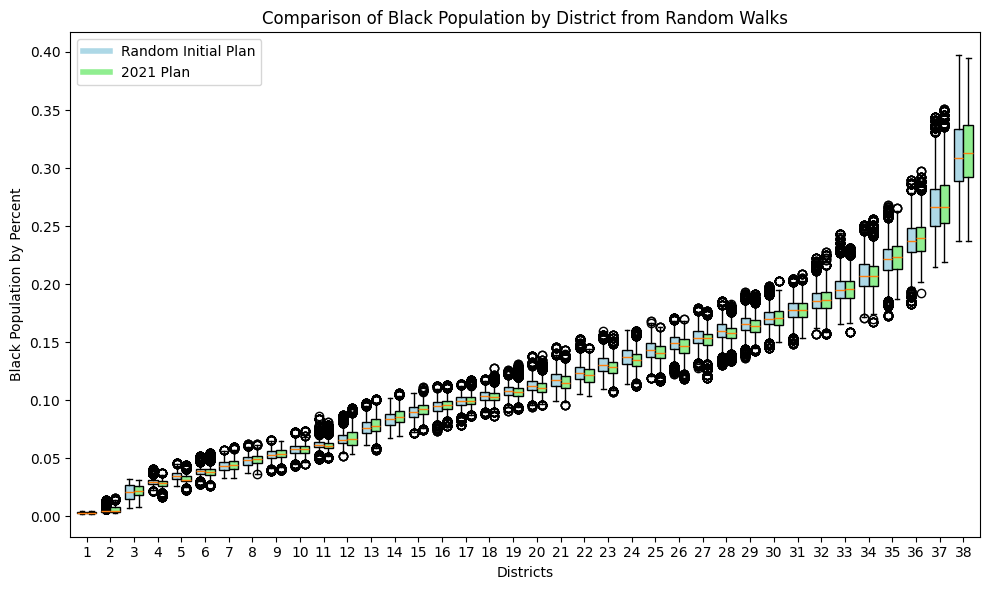

In [142]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)] 
positions_2021 = [x + 0.2 for x in range(1, num_dist + 1)]

# Plot boxplots for black population from random initial plan
ax.boxplot(bpop_rand, positions=positions_rand, widths=0.4, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(bpop_2021, positions=positions_2021, widths=0.4, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['Random Initial Plan', '2021 Plan'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Black Population by Percent')
ax.set_title('Comparison of Black Population by District from Random Walks')

plt.tight_layout()
plt.show()

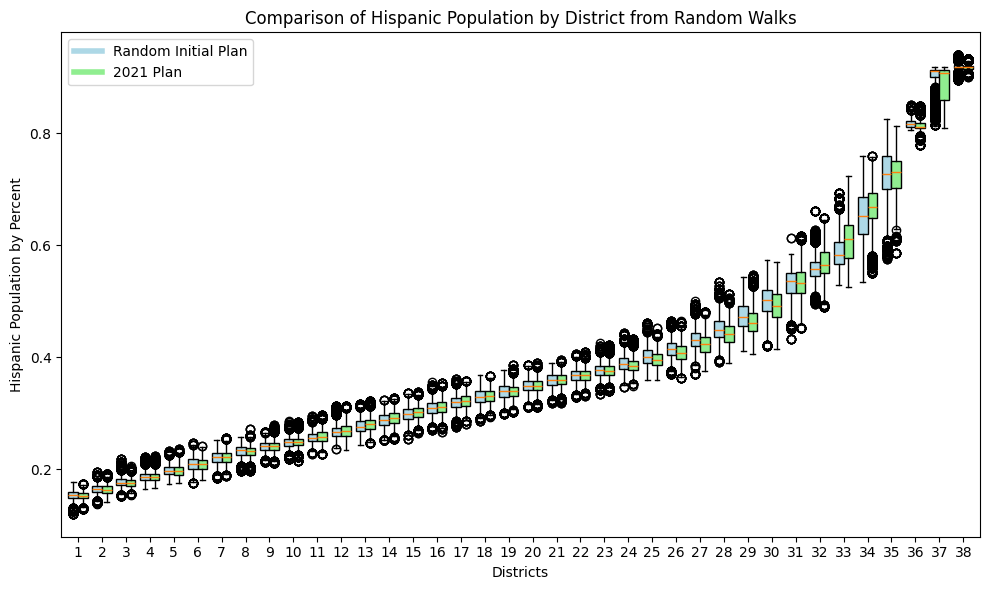

In [143]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)] 
positions_2021 = [x + 0.2 for x in range(1, num_dist + 1)]

# Plot boxplots for black population from random initial plan
ax.boxplot(hpop_rand, positions=positions_rand, widths=0.4, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(hpop_2021, positions=positions_2021, widths=0.4, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['Random Initial Plan', '2021 Plan'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Hispanic Population by Percent')
ax.set_title('Comparison of Hispanic Population by District from Random Walks')

plt.tight_layout()
plt.show()

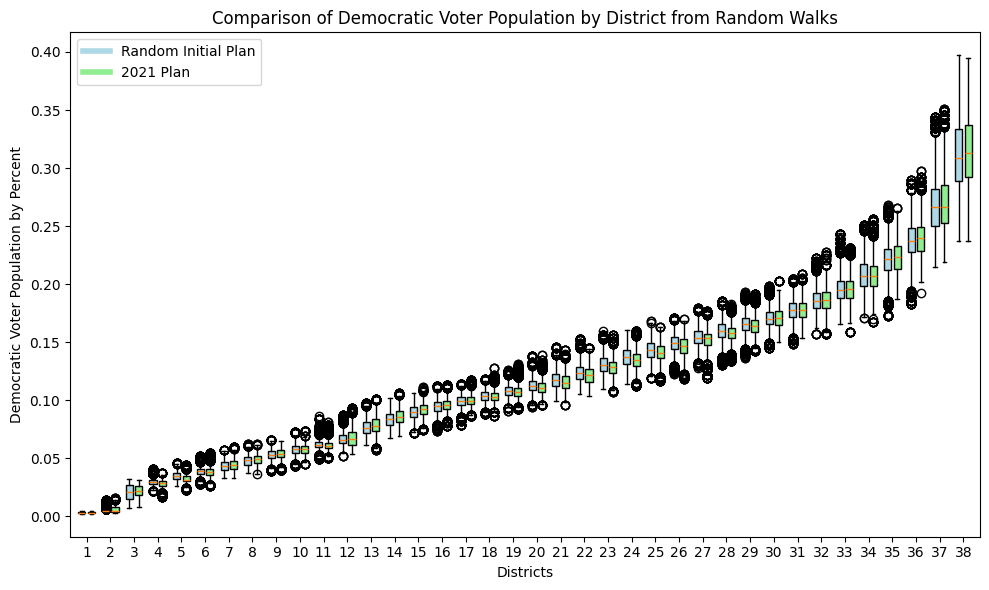

In [144]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)] 
positions_2021 = [x + 0.2 for x in range(1, num_dist + 1)]  

# Plot boxplots for black population from random initial plan
ax.boxplot(dvpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(dvpop_2021, positions=positions_2021, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['Random Initial Plan', '2021 Plan'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Democratic Voter Population by Percent')
ax.set_title('Comparison of Democratic Voter Population by District from Random Walks')

plt.tight_layout()
plt.show()

### Run random initial one for more 20,000 steps instead of 10,0000

In [145]:
#Set up partition object
initial_partition = Partition(
    tx_graph, # dual graph
    assignment = initial_plan, # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("NHBLK", alias = "district BPOP"),
        "district HPOP": Tally("HISPPOP", alias = "district HPOP"),
        "R Votes": Tally("G20PRERTRU", alias = "R Votes"), 
        "D Votes": Tally("G20PREDBID", alias = "D Votes")
    }
) 

In [146]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [147]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [148]:
random_walk_more_steps = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 20000
)

In [149]:
bmaj_ensemble = []
d_ensemble = [] 
hmaj_ensemble = [] 
bpop = [] 
dvpop = []
hpop = []

for current_plan in our_random_walk:    
    num_maj_black = 0
    num_maj_hisp = 0
    d = 0
    bpop_this_step = []
    dv_this_step = []
    hpop_this_step = []

    for i in range(num_dist):
        # Calculate number of black-majority districts 
        b_perc = current_plan["district BPOP"][i]/current_plan["district population"][i]
        if b_perc >= 0.37:
            num_maj_black += 1

        # Calculate number of hispanic-majority districts 
        h_perc = current_plan["district HPOP"][i]/current_plan["district population"][i]
        if h_perc >= 0.37:
            num_maj_hisp += 1
        
        # Calculate number of districts with more Democratic votes than Republican votes
        if current_plan["R Votes"][i] < current_plan["D Votes"][i]: 
            d = d + 1

        # Calculate the percentage of black population for each district at each step
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)

        # Calculate the percentage of hispanic population for each district at each step
        h_perc = current_plan["district HPOP"][i]/ current_plan["district population"][i]
        hpop_this_step.append(h_perc)

         # Calculate the percentage of democratic voters for each district at each step
        dv_perc = current_plan["D Votes"][i]/ current_plan["district population"][i]
        dv_this_step.append(dv_perc)
    
        
    bmaj_ensemble.append(num_maj_black)
    hmaj_ensemble.append(num_maj_hisp)
    d_ensemble.append(d)

    bpop_this_step.sort()
    bpop.append(bpop_this_step)

    hpop_this_step.sort()
    hpop.append(hpop_this_step)

    dv_this_step.sort()
    dvpop.append(bpop_this_step)

bpop_more_steps = np.array(bpop)
dvpop_more_steps = np.array(dvpop)
hpop_more_steps = np.array(hpop)

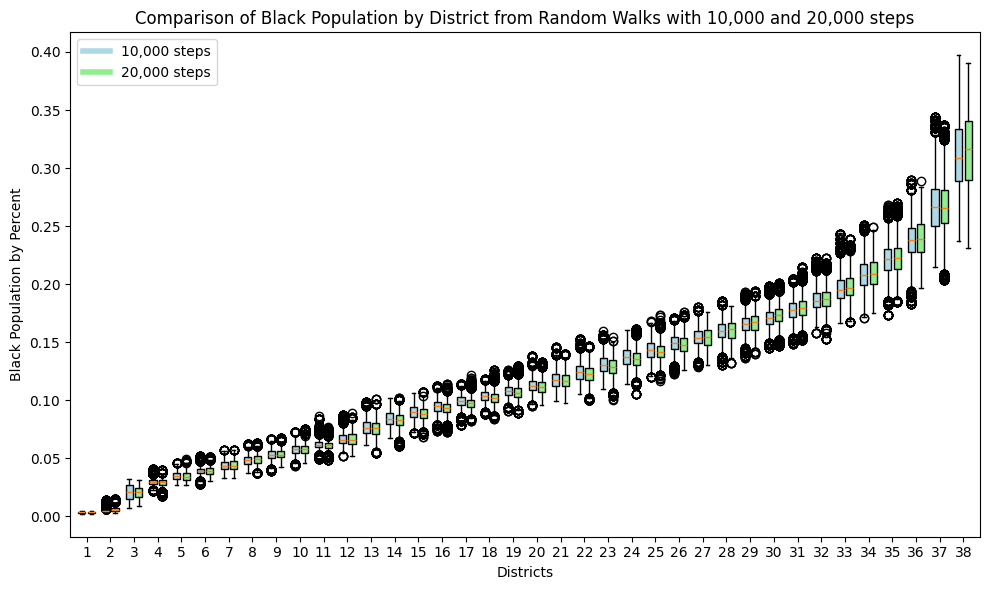

In [150]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)] 
positions_more_steps = [x + 0.2 for x in range(1, num_dist + 1)] 

# Plot boxplots for black population from random initial plan with 10000 steps
ax.boxplot(bpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(bpop_more_steps, positions=positions_more_steps, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['10,000 steps', '20,000 steps'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Black Population by Percent')
ax.set_title('Comparison of Black Population by District from Random Walks with 10,000 and 20,000 steps')

plt.tight_layout()
plt.show()

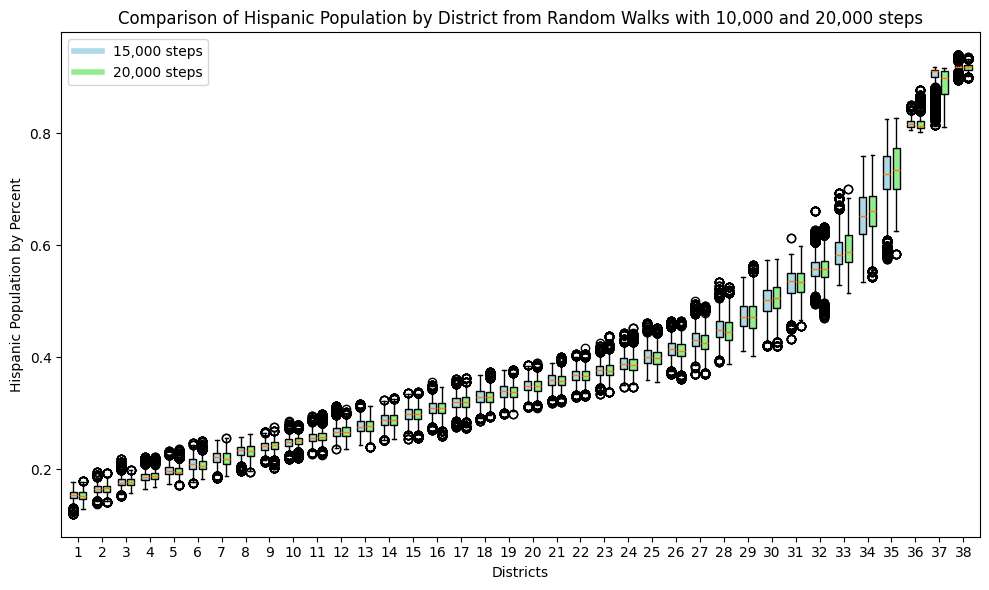

In [151]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)] 
positions_more_steps = [x + 0.2 for x in range(1, num_dist + 1)] 

# Plot boxplots for black population from random initial plan with 10000 steps
ax.boxplot(hpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(hpop_more_steps, positions=positions_more_steps, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['15,000 steps', '20,000 steps'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Hispanic Population by Percent')
ax.set_title('Comparison of Hispanic Population by District from Random Walks with 10,000 and 20,000 steps')

plt.tight_layout()
plt.show()

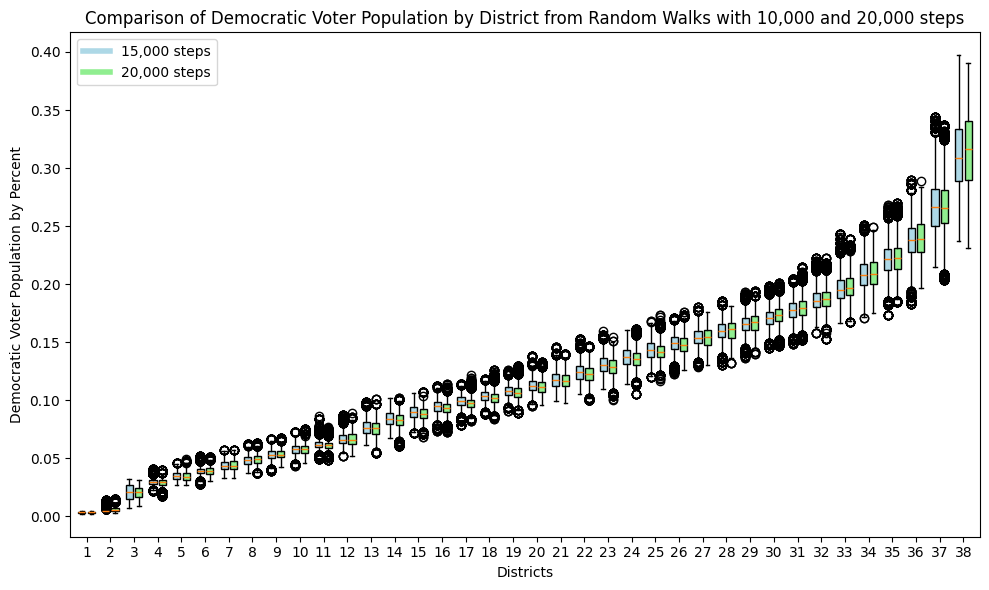

In [152]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)]  
positions_more_steps = [x + 0.2 for x in range(1, num_dist + 1)] 

# Plot boxplots for black population from random initial plan with 10000 steps
ax.boxplot(dvpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(dvpop_more_steps, positions=positions_more_steps, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['15,000 steps', '20,000 steps'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Democratic Voter Population by Percent')
ax.set_title('Comparison of Democratic Voter Population by District from Random Walks with 10,000 and 20,000 steps')

plt.tight_layout()
plt.show()

Looks like our random walk ran for long enough.